# Setup

In [1]:
import pickle
import matplotlib.pyplot as plt
import sys
import os
module_path = os.path.abspath(os.path.join('/home/razorin/tabularts/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import dataset
import torch
from pprint import pprint
import pandas as pd
import seaborn as sns
import sklearn
from  sklearn.manifold import TSNE
from  sklearn.decomposition import PCA
from  sklearn.preprocessing import KBinsDiscretizer
from  sklearn.preprocessing import MinMaxScaler
from  sklearn.preprocessing import RobustScaler
from  sklearn.preprocessing import StandardScaler
from  sklearn.preprocessing import QuantileTransformer
import numpy as np
import math

In [2]:
pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', -1)

In [3]:
data_type = "kdd"
name_suffix = ""

In [4]:
if data_type == "kdd":
    with open(f"./kdd/KDDDataset_ft{name_suffix}.pkl", "rb") as f:
        dataset = pickle.load(f)

# Full data

In [5]:
# FYI: Accounts order when the dataset samples were preprared
accounts = []
for group in dataset.data.groupby("account_id"):
    account_name = group[0]
    accounts.append(account_name)
print(accounts)

[2, 19, 25, 37, 38, 67, 97, 103, 105, 110, 132, 173, 176, 226, 276, 290, 303, 309, 314, 319, 330, 339, 344, 347, 349, 378, 426, 440, 442, 472, 501, 525, 544, 666, 675, 718, 785, 789, 790, 808, 813, 816, 817, 825, 846, 854, 873, 915, 938, 940, 960, 993, 1004, 1011, 1012, 1068, 1071, 1083, 1093, 1106, 1166, 1242, 1244, 1247, 1250, 1252, 1256, 1270, 1284, 1318, 1329, 1374, 1375, 1389, 1407, 1447, 1480, 1498, 1527, 1528, 1580, 1583, 1603, 1638, 1656, 1698, 1718, 1762, 1766, 1772, 1776, 1787, 1801, 1808, 1811, 1819, 1843, 1862, 1869, 1876, 1886, 1888, 1906, 1928, 1967, 1978, 1993, 2000, 2018, 2035, 2051, 2055, 2062, 2064, 2073, 2080, 2106, 2116, 2134, 2142, 2143, 2153, 2165, 2167, 2176, 2187, 2218, 2227, 2228, 2236, 2245, 2246, 2247, 2262, 2268, 2279, 2322, 2334, 2335, 2343, 2345, 2350, 2352, 2361, 2413, 2419, 2445, 2456, 2486, 2496, 2516, 2545, 2572, 2580, 2622, 2694, 2699, 2705, 2720, 2725, 2728, 2753, 2754, 2762, 2824, 2872, 2910, 2912, 2933, 2936, 2962, 2982, 2986, 2988, 2994, 3005, 302

In [6]:
# FYI: raw initial data
os.chdir("/home/razorin/tabularts/")
raw_data = pd.read_csv(dataset.data_root)
raw_data["date_raw"] = "19" + raw_data["Year"].astype(str) + "-" + raw_data["Month"].astype(str) + "-" + raw_data["Day"].astype(str)
raw_data["date_raw"] = pd.to_datetime(raw_data["date_raw"], format="%Y-%m-%d")
raw_data['weekday'] = raw_data['date_raw'].dt.dayofweek
raw_data = raw_data.sort_values(by=["date_raw"])
raw_data

,account_id,Day,Month,Year,amount_trans,balance,k_symbol,operation,type_trans,status,date_raw,weekday
299,5270,13,1,93,0.009153,0.167193,2,3,0,0,1993-01-13,2
134,11265,14,1,93,0.011442,0.167990,2,3,0,0,1993-01-14,3
300,5270,14,1,93,0.512002,0.345644,2,2,0,0,1993-01-14,3
254,10364,17,1,93,0.012586,0.168389,2,3,0,0,1993-01-17,6
5539,3834,19,1,93,0.008009,0.166794,2,3,0,0,1993-01-19,1
...,...,...,...,...,...,...,...,...,...,...,...,...
54573,1928,30,11,98,0.001914,0.317390,7,0,0,0,1998-11-30,0
54268,105,2,12,98,0.065217,0.284337,2,4,2,0,1998-12-02,2
54267,105,2,12,98,0.138444,0.307067,2,3,0,0,1998-12-02,2
54459,6922,3,12,98,0.291762,0.355244,2,4,2,0,1998-12-03,3


In [7]:
raw_data.columns

Index(['account_id', 'Day', 'Month', 'Year', 'amount_trans', 'balance',
       'k_symbol', 'operation', 'type_trans', 'status', 'date_raw', 'weekday'],
      dtype='object')

In [8]:
dataset.data

,amount_trans,balance,k_symbol,operation,type_trans,Year,Month,Day,weekday,timestamp_int,account_id,status
299,12.0,51.0,103.0,112.0,115.0,118.0,124.0,140.0,169.0,174.0,5270,0.0
134,13.0,51.0,103.0,112.0,115.0,118.0,124.0,141.0,170.0,174.0,11265,0.0
300,45.0,79.0,103.0,111.0,115.0,118.0,124.0,141.0,170.0,174.0,5270,0.0
254,14.0,51.0,103.0,112.0,115.0,118.0,124.0,144.0,173.0,174.0,10364,0.0
5539,12.0,51.0,103.0,112.0,115.0,118.0,124.0,146.0,168.0,174.0,3834,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
54573,48.0,73.0,108.0,109.0,115.0,123.0,126.0,159.0,167.0,217.0,1928,0.0
54268,29.0,65.0,103.0,113.0,117.0,123.0,127.0,147.0,169.0,217.0,105,0.0
54267,36.0,71.0,103.0,112.0,115.0,123.0,127.0,147.0,169.0,217.0,105,0.0
54459,43.0,81.0,103.0,113.0,117.0,123.0,127.0,158.0,170.0,217.0,6922,0.0


In [9]:
preproc_data = dataset.data # Do NOT sort again (keep original timestamp sort)
preprocessed_data = []
for group, data in preproc_data.groupby("account_id"):
    preprocessed_data.append(data)
preprocessed_data = pd.concat(preprocessed_data)
preprocessed_data

,amount_trans,balance,k_symbol,operation,type_trans,Year,Month,Day,weekday,timestamp_int,account_id,status
612,14.0,51.0,103.0,112.0,115.0,118.0,128.0,154.0,171.0,174.0,2,0.0
613,40.0,53.0,103.0,111.0,115.0,118.0,129.0,139.0,171.0,174.0,2,0.0
614,24.0,58.0,103.0,112.0,115.0,118.0,129.0,156.0,173.0,174.0,2,0.0
615,7.0,58.0,108.0,109.0,115.0,118.0,129.0,160.0,169.0,174.0,2,0.0
616,40.0,79.0,103.0,111.0,115.0,118.0,130.0,139.0,167.0,174.0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
24489,47.0,75.0,101.0,110.0,117.0,121.0,127.0,163.0,171.0,187.0,11362,0.0
24491,10.0,64.0,104.0,110.0,117.0,121.0,127.0,164.0,172.0,187.0,11362,0.0
24490,35.0,64.0,103.0,113.0,117.0,121.0,127.0,164.0,172.0,187.0,11362,0.0
24492,19.0,64.0,101.0,110.0,117.0,121.0,127.0,165.0,173.0,187.0,11362,0.0


In [10]:
samples = dataset.samples
print(len(samples))

targets = dataset.targets
print(len(targets))

print(preprocessed_data["account_id"].drop_duplicates().shape[0])

682
682
682


In [11]:
vocab_keys = list(dataset.vocab.token2id.keys())
for k in vocab_keys:
    print(f"\n--{k}--")
    # pprint(dataset.vocab.token2id[k])
    print(len(dataset.vocab.token2id[k]))


--SPECIAL--
7

--amount_trans--
44

--balance--
50

--k_symbol--
8

--operation--
6

--type_trans--
3

--Year--
6

--Month--
12

--Day--
31

--weekday--
7

--timestamp_int--
50


In [12]:
dataset.vocab.token2id["SPECIAL"]

OrderedDict([('[UNK]', [0, 0]),
             ('[SEP]', [1, 1]),
             ('[PAD]', [2, 2]),
             ('[CLS]', [3, 3]),
             ('[MASK]', [4, 4]),
             ('[BOS]', [5, 5]),
             ('[EOS]', [6, 6])])

# Sample

In [13]:
raw_data["account_id"].drop_duplicates().sort_values()

612          2
18059       19
38144       25
52596       37
45057       38
         ...  
51967    11327
49875    11328
14298    11349
20807    11359
24387    11362
Name: account_id, Length: 682, dtype: int64

In [14]:
sample_id = 1
stride = 150
final_id = sample_id

# If pre-training dataset
raw_sample = raw_data[raw_data["account_id"] == final_id + 1][:stride]
preprocessed_sample = preprocessed_data[preprocessed_data["account_id"] == final_id + 1][:stride]

# If fine-tuning dataset, check the offset depending on the account_ids included in the dataset (cf. cell above)
offset = 18
raw_sample = raw_data[raw_data["account_id"] == final_id + offset][:stride]
preprocessed_sample = preprocessed_data[preprocessed_data["account_id"] == final_id + offset][:stride]

pytorch_sample = torch.tensor(samples[sample_id]).reshape(-1, dataset.ncols) # Not always the same seq_len
pytorch_target = torch.tensor(targets[sample_id])

In [15]:
raw_sample 

,account_id,Day,Month,Year,amount_trans,balance,k_symbol,operation,type_trans,status,date_raw,weekday
18059,19,7,4,95,0.011442,0.167990,2,3,0,1,1995-04-07,4
18060,19,10,4,95,0.173215,0.228362,2,2,0,1,1995-04-10,0
18061,19,30,4,95,0.000539,0.228737,7,0,0,1,1995-04-30,6
18062,19,30,4,95,0.000539,0.228550,7,0,0,1,1995-04-30,6
18063,19,7,5,95,0.050343,0.246284,2,3,0,1,1995-05-07,6
...,...,...,...,...,...,...,...,...,...,...,...,...
18134,19,31,3,96,0.000959,0.228788,7,0,0,1,1996-03-31,6
18133,19,31,3,96,0.000957,0.229122,7,0,0,1,1996-03-31,6
18136,19,1,4,96,0.029748,0.239432,2,3,0,1,1996-04-01,0
18137,19,6,4,96,0.208238,0.166854,5,4,2,1,1996-04-06,5


In [16]:
preprocessed_sample

,amount_trans,balance,k_symbol,operation,type_trans,Year,Month,Day,weekday,timestamp_int,account_id,status
18059,13.0,51.0,103.0,112.0,115.0,120.0,130.0,164.0,171.0,221.0,19,1.0
18060,38.0,85.0,103.0,111.0,115.0,120.0,130.0,137.0,167.0,221.0,19,1.0
18061,8.0,85.0,108.0,109.0,115.0,120.0,130.0,159.0,173.0,222.0,19,1.0
18062,8.0,85.0,108.0,109.0,115.0,120.0,130.0,159.0,173.0,222.0,19,1.0
18063,26.0,53.0,103.0,112.0,115.0,120.0,131.0,164.0,173.0,222.0,19,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18134,30.0,85.0,108.0,109.0,115.0,121.0,129.0,160.0,173.0,180.0,19,1.0
18133,30.0,85.0,108.0,109.0,115.0,121.0,129.0,160.0,173.0,180.0,19,1.0
18136,20.0,98.0,103.0,112.0,115.0,121.0,130.0,136.0,167.0,180.0,19,1.0
18137,39.0,51.0,106.0,113.0,117.0,121.0,130.0,163.0,172.0,180.0,19,1.0


In [17]:
pytorch_sample

tensor([[ 13.,  51., 103., 112., 115., 120., 130., 164., 171., 221.],
        [ 38.,  85., 103., 111., 115., 120., 130., 137., 167., 221.],
        [  8.,  85., 108., 109., 115., 120., 130., 159., 173., 222.],
        [  8.,  85., 108., 109., 115., 120., 130., 159., 173., 222.],
        [ 26.,  53., 103., 112., 115., 120., 131., 164., 173., 222.],
        [ 38.,  71., 103., 111., 115., 120., 131., 137., 169., 222.],
        [ 46.,  71., 108., 109., 115., 120., 131., 160., 169., 222.],
        [ 46.,  71., 108., 109., 115., 120., 131., 160., 169., 222.],
        [ 21.,  68., 103., 113., 117., 120., 132., 163., 168., 222.],
        [ 42.,  86., 103., 111., 115., 120., 132., 137., 172., 222.],
        [ 50.,  86., 108., 109., 115., 120., 132., 159., 171., 223.],
        [ 50.,  86., 108., 109., 115., 120., 132., 159., 171., 223.],
        [ 37.,  77., 103., 113., 117., 120., 133., 163., 170., 223.],
        [ 38.,  87., 103., 111., 115., 120., 133., 137., 167., 223.],
        [ 50.,  87.,

In [18]:
pytorch_target

tensor(1., dtype=torch.float64)

In [19]:
# Note: Need padding
# dataset.samples[0].shape
# dataset.samples[758].shape

# Other note:
# The notebook is very slow. Is it because the pickled dataset is heavy?

# Explore (fine tuning dataset)

In [20]:
# if finetuning dataset: check class imbalance
print(raw_data[["account_id", "status"]].drop_duplicates().groupby("status").count())
print(preprocessed_data[["account_id", "status"]].drop_duplicates().groupby("status").count())
print(torch.unique(torch.tensor(dataset.targets), return_counts=True))
print(76/(606+76))

        account_id
status            
0              606
1               76
        account_id
status            
0.0            606
1.0             76
(tensor([0., 1.], dtype=torch.float64), tensor([606,  76]))
0.11143695014662756


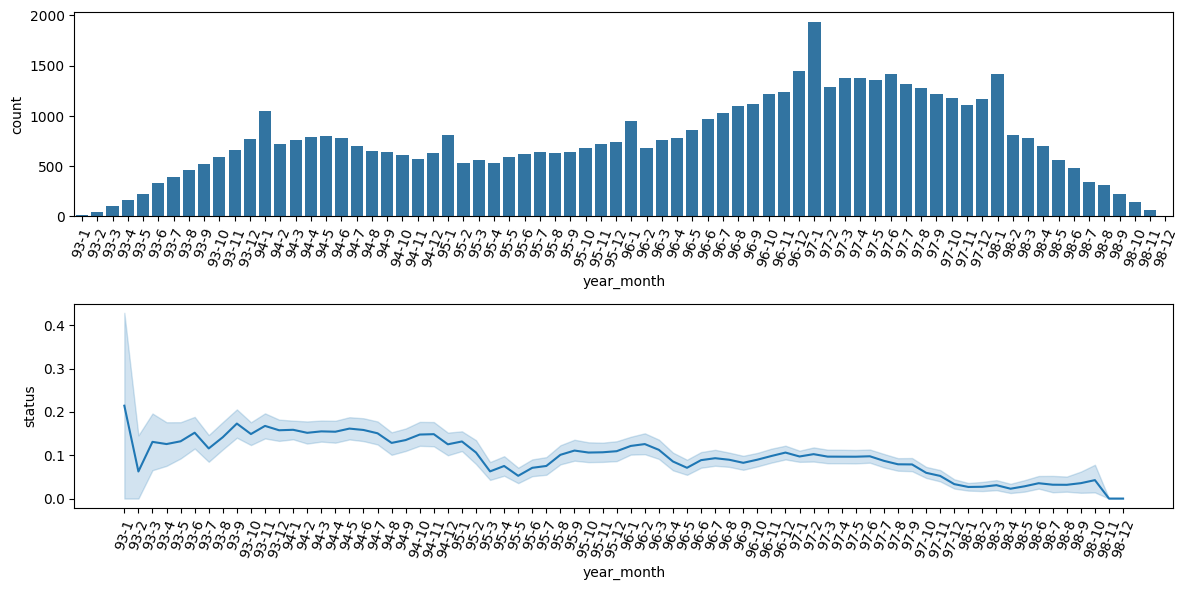

In [21]:
# Number of transactions and Evolution of fraud over the years

raw_data_ym = raw_data.copy(deep=True)
raw_data_ym["year_month"] = raw_data_ym["Year"].astype(str) + "-" + raw_data_ym["Month"].astype(str)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))
sns.countplot(
    ax=ax1,
    x='year_month', 
    data=raw_data_ym,
)
sns.lineplot(
    ax=ax2,
    x='year_month', 
    y='status', 
    data=raw_data_ym,
    estimator="mean", # Aggregate the frauds by avging them
)

ax1.tick_params(axis='x', labelrotation=70)
ax2.tick_params(axis='x', labelrotation=70)
plt.tight_layout()

# Take aways: 
# 2x more transactions in 1996 and 1997
# Always more transactions in January
# Fraud slowly decreases over time
# No obvious seasonality

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


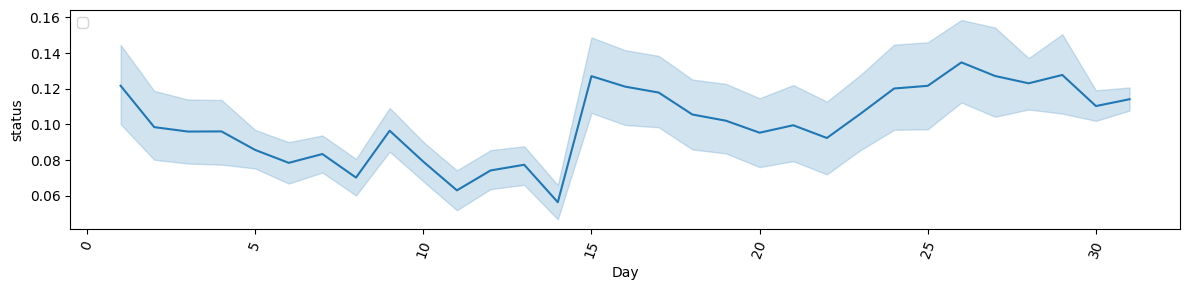

In [22]:
# Evolution of fraud by day of the month

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
sns.lineplot(
    ax=ax,
    x='Day', 
    y='status',
    estimator="mean", 
    data=raw_data,
)
ax.legend(loc='upper left', ncol=6)
ax.tick_params(axis='x', labelrotation=70)
plt.tight_layout()

# Take aways: 
# - day of the month matters
# - more fraud in the second half of the month

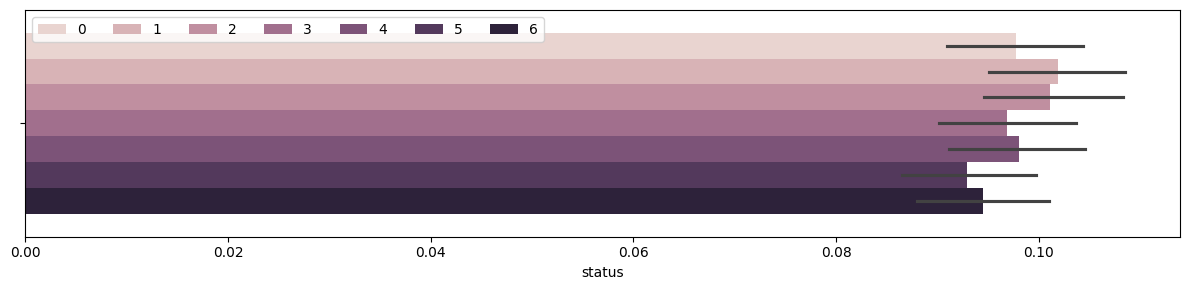

In [23]:
# Evolution of fraud by weekday

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
sns.barplot(
    ax=ax,
    x='status', 
    hue='weekday',
    data=raw_data,
    estimator="mean",
)
ax.legend(loc='upper left', ncol=7)
ax.tick_params(axis='x', labelrotation=0)
plt.tight_layout()

# Take aways: 
# - day of the week matters a little bit

<Axes: xlabel='balance', ylabel='amount_trans'>

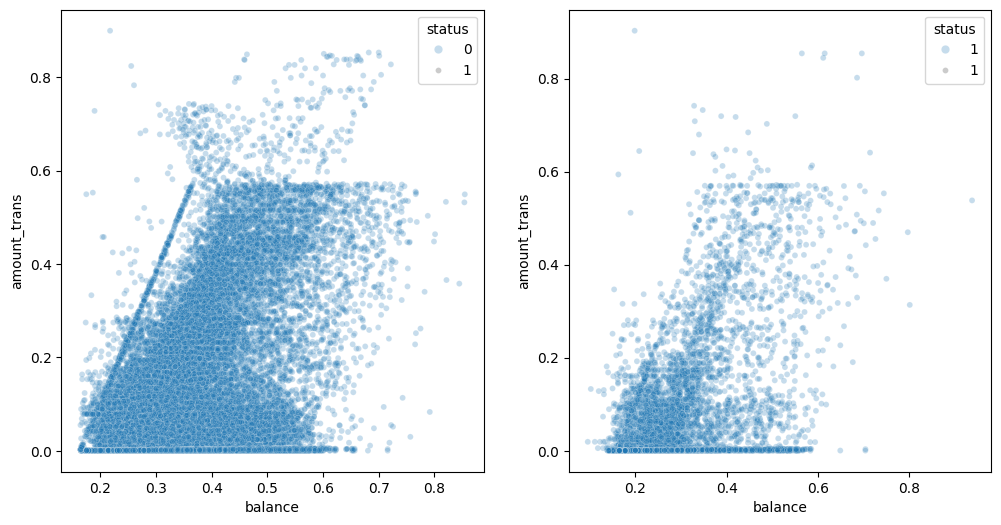

In [24]:
# Numerical variables
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.scatterplot(
    ax=ax1,
    data=raw_data[raw_data["status"] == 0],
    y="amount_trans", 
    x='balance',
    hue="status",
    alpha=0.25,
    size=1,
)
sns.scatterplot(
    ax=ax2,
    data=raw_data[raw_data["status"] == 1],
    y="amount_trans", 
    x='balance',
    alpha=0.25,
    hue="status",
    size=1,
)

# Take away:
# - Numerical features alone do not seem indicative of Fraud
# - transaction amount correlates positively with account balance (not surprising)

<Axes: xlabel='type_trans', ylabel='count'>

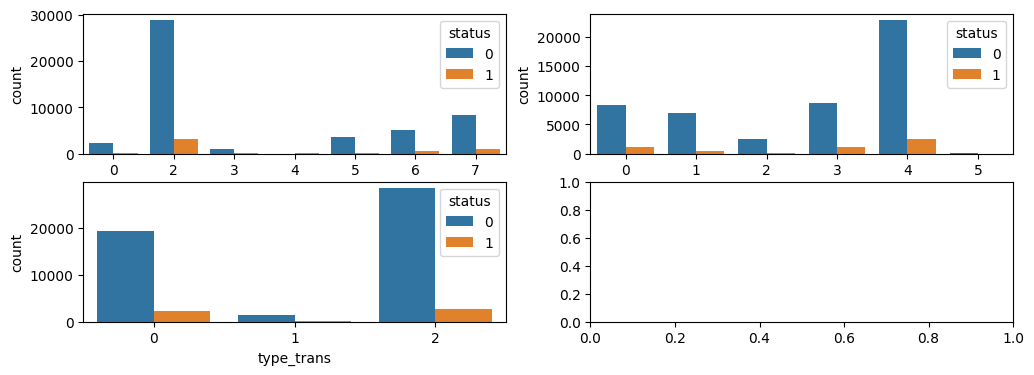

In [25]:
# categorical variable data exploration
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))
sns.countplot(
    ax=ax1,
    x='k_symbol', 
    hue='status', 
    data=raw_data,
)
sns.countplot(
    ax=ax2,
    x='operation', 
    hue='status', 
    data=raw_data,
)
sns.countplot(
    ax=ax3,
    x='type_trans', 
    hue='status', 
    data=raw_data,
)

# Take-away:
# More type_trans == 2 for Frauds